# Vinted Case Study

# Importing, examining and executing primary cleaning of data

In [76]:
import warnings
warnings.filterwarnings('ignore')

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, chi2_contingency, pearsonr, fisher_exact

In [78]:
file_path = 'dataset.csv'
df = pd.read_csv(file_path, index_col=0)

In [79]:
# converting columns to right datatypes and localizing datetime
datetype_columns = ['created_at', 'sale_time', 'declined_at', 'first_listing_local_date']
category_columns = ['listing_platform', 'registration_platform', 'gender', 'country_code', 'listings_in_first_7days_detailed',
                    'catalog_code_1', 'catalog_code_2', 'catalog_code_3', 'catalog_code_4', 'catalog_code_5']
df[datetype_columns] = df[datetype_columns].apply(pd.to_datetime)
df[datetype_columns] = df[datetype_columns].apply(lambda x: x.dt.tz_localize(None))
df[category_columns] = df[category_columns].apply(lambda x: x.astype('category'))
df['brand_is_verified'] = df['brand_is_verified'].astype(bool)

In [80]:
# removing rows with sale_time less then create_time
df = df[((df['sale_time'].isnull()) | (df['sale_time'] >= df['created_at']))]

# column indicating if item was sold
df['is_sold'] = ~df['sale_time'].isna()

# age of listing for not sold items where current date is considered as the max of sale_time
df['listing_age_days'] = np.where(df['is_sold'], 
                                  (df['sale_time'] - df['created_at']).dt.days, 
                                  (df['sale_time'].max() - df['created_at']).dt.days)

In [81]:
df.columns, df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 600095 entries, 0 to 600098
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   portal                            600095 non-null  object        
 1   id                                600095 non-null  object        
 2   created_at                        600095 non-null  datetime64[ns]
 3   user_id                           600095 non-null  object        
 4   listing_price_eur_fixed           600095 non-null  float64       
 5   status                            600095 non-null  object        
 6   sale_time                         175351 non-null  datetime64[ns]
 7   gmv_eur_fixed                     175351 non-null  float64       
 8   brand                             530624 non-null  object        
 9   brand_is_verified                 600095 non-null  bool          
 10  declined_at                       154

(Index(['portal', 'id', 'created_at', 'user_id', 'listing_price_eur_fixed',
        'status', 'sale_time', 'gmv_eur_fixed', 'brand', 'brand_is_verified',
        'declined_at', 'color_primary', 'listing_quality_string',
        'suggested_price_maximum', 'catalog_code_1', 'catalog_code_2',
        'catalog_code_3', 'catalog_code_4', 'catalog_code_5', 'gender',
        'country_code', 'lister_nth_listing', 'first_listing_local_date',
        'listing_platform', 'registration_platform', 'registration_local_date',
        'total_positive_feedback_count', 'total_negative_feedback_count',
        'window_items_listed', 'window_items_bought', 'window_items_sold',
        'listings_in_first_7days_detailed', 'is_sold', 'listing_age_days'],
       dtype='object'),
   portal                                    id          created_at  \
 0     fr  7d121616-26aa-489d-b224-714caa6577cb 2021-08-08 12:48:22   
 1     fr  98ef06e2-8147-44be-9dd3-fa210ef525a5 2021-08-06 10:31:00   
 2     fr  38116fbf-2

In [82]:
data = df.copy()

# Section I: Defining Liquidity

## Cons of defining STR as Total sold listings / All listings

Eventhough suggested definition of STR wouldn't be a bad metric for averall liquidity measurment, it is still *misleading*, due to number of factors.
- **Time sensitivity**: it is not correct to treat listings that are sold in one day and ones in 30 days as the same thing.
- **Fresh listings**: items that were put on the market recently can skew STR (maybe they didn't have enough time to be sold).

In [83]:
# calculating suggested value of STR
str_suggested = len(data[data['is_sold'] == True]) / len(data['is_sold'])
print(f"STR as Total sold listings / All listings: {round(str_suggested * 100, 2)} %")

STR as Total sold listings / All listings: 29.22 %


## How can we improve STR as a liquidity metric?

Previously we difined *'listing_age_days'* column that we can use to link to the items that we will include in the analysis:\
From the graph below we can see that majority of unsold listings are older than 30 days, and probably they did not have enough chance to be sold. So it can be tried calculating STRs of listings that are older and younger than 30 days. 

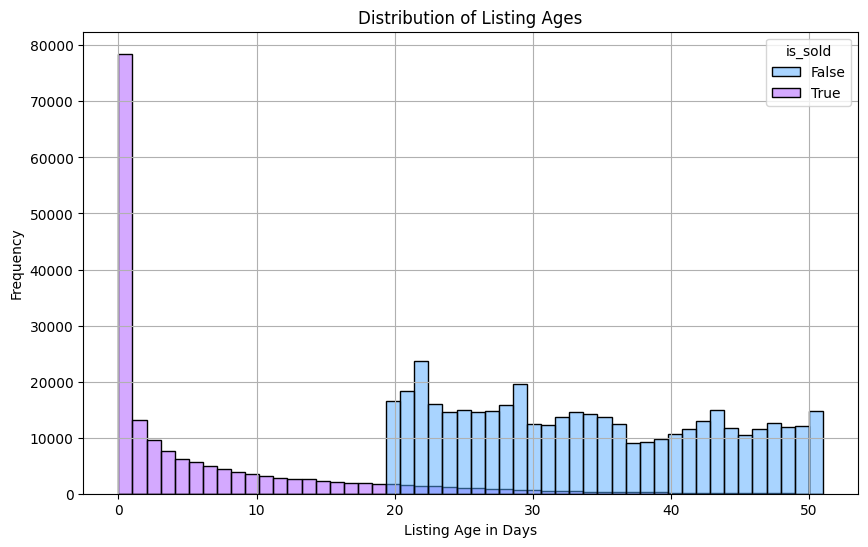

In [84]:
# Plotting the distribution of listing ages
plt.figure(figsize=(10, 6))
# plt.hist(data['listing_age_days'], bins=50, color='skyblue', edgecolor='black')
sns.histplot(data=data, x='listing_age_days', hue='is_sold', bins=50, palette='cool', edgecolor='black')
plt.title('Distribution of Listing Ages')
plt.xlabel('Listing Age in Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [85]:
# calculating strs
listings_older_than_30_days = data[data['listing_age_days'] > 30]
listings_younger_than_30_days = data[data['listing_age_days'] <= 30]

str_n = listings_older_than_30_days['sale_time'].notna().sum()
str_d = len(listings_older_than_30_days)
calculated_str = str_n / str_d
print(f"STR for listings older than 30 days: {round(calculated_str * 100, 2)} %")

str_n = listings_younger_than_30_days['sale_time'].notna().sum()
str_d = len(listings_younger_than_30_days)
calculated_str = str_n / str_d
print(f"STR for listings younger than 30 days: {round(calculated_str * 100, 2)} %")


STR for listings older than 30 days: 1.8 %
STR for listings younger than 30 days: 48.55 %


## Formulating hypotheses about possible factors infuencing Liquidity

*Possible* factors influencing Liquidity:
- **Price of Listing**: Listings priced closer to market expectations (e.g., near the suggested price) might sell faster.
- **Item Condition**: Items in better condition are generally more attractive and may sell quicker.
- **User Feedback and Reputation**: if the amount of positive feedback correlates with higher STR.

# Section II: Modeling Liquidity

## Hypotheses testing

### Price of Listing
- H0: There is no relationship between sell time and price being close to the suggested pricing.
- H1: There is a relationship.
- Rationing: Items priced competitively (below suggested price) are more likely to sell quicker than ones that are with higher prices. 

In [86]:
# price difference ratio and handling zero division
data['price_diff_ratio'] = data['listing_price_eur_fixed'] / data['suggested_price_maximum']
data['price_diff_ratio'].replace([float('inf'), float('-inf')], float('nan'), inplace=True)

price_diff_data = data[['price_diff_ratio', 'is_sold']].dropna()

# there are definetly some outliers in the data, that we will remove with IQR
Q1 = price_diff_data['price_diff_ratio'].quantile(0.25)
Q3 = price_diff_data['price_diff_ratio'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_price_diff_data = price_diff_data[(price_diff_data['price_diff_ratio'] >= lower_bound) & (price_diff_data['price_diff_ratio'] <= upper_bound)]

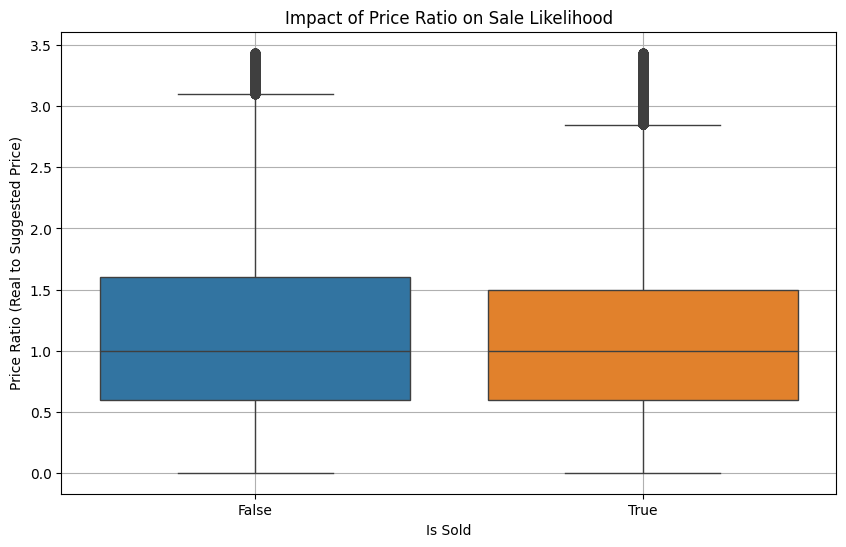

In [87]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_sold', y='price_diff_ratio', data=filtered_price_diff_data, hue='is_sold', legend=False)
plt.title('Impact of Price Ratio on Sale Likelihood')
plt.xlabel('Is Sold')
plt.ylabel('Price Ratio (Real to Suggested Price)')
plt.grid(True)
plt.show()

Though it can be observed that sold listing tend to be closer to the suggested price (tend to 1), it is still not clear wether there is a difference.
Further testing can be concluded to decide if the difference is significant.

In [88]:
# using Mann-Whitney U test to determine if there is a difference between sold and not-sold items' price ratio
sold_prices = filtered_price_diff_data[filtered_price_diff_data['is_sold']]['price_diff_ratio']
not_sold_prices = filtered_price_diff_data[~filtered_price_diff_data['is_sold']]['price_diff_ratio']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(sold_prices, not_sold_prices, alternative='two-sided')

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")

stat, p_value

Reject the null hypothesis. There is a significant difference.


(28798229393.5, 3.040124857171365e-203)

**Conclusion**: eventhough it wasn't clear from the beginning on the box-plots wether there is a significant difference, Mann-Whitney U test confirms there is a big probability of said difference to exist.

### Item Condition
- H0: There is no relationship between listing condition and sale time.
- H1: There is a relationship.
- Rationing: Better condition items may tend to sell faster.

In [89]:
condition_sales_data = df.groupby('status')['is_sold'].mean().reset_index()

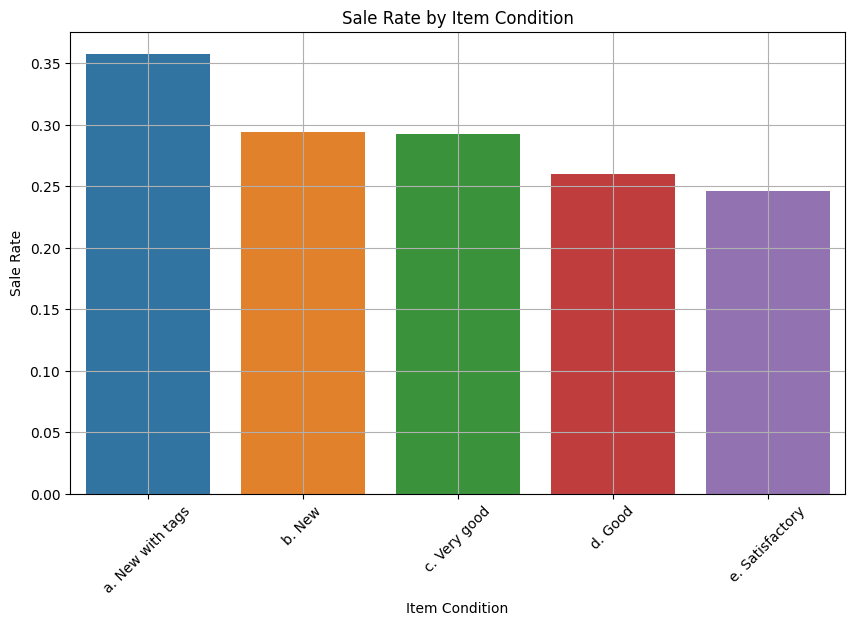

In [90]:
plt.figure(figsize=(10, 6))
sns.barplot(x='status', y='is_sold', data=condition_sales_data, hue='status')
plt.title('Sale Rate by Item Condition')
plt.xlabel('Item Condition')
plt.ylabel('Sale Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Though it can be observed that sold listing tend to be closer to the suggested price (tend to 1), it is still not clear wether there is a difference.
Further testing can be concluded to decide if the difference is significant.

In [91]:
# chi-square test
condition_sold_counts = data.pivot_table(index='status', columns='is_sold', aggfunc='size', fill_value=0)
chi2, p_value, dof, expected = chi2_contingency(condition_sold_counts)

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")
    
chi2, p_value

Reject the null hypothesis. There is a significant difference.


(1868.4017399241545, 0.0)

**Conclusion**: can be confirmed from the chi-square test that there is a significant difference.

### User Feedback and Reputation
- H0: There is no relationship between User Feedback and Reputation and sale time.
- H1: There is a relationship.
- Rationing: Better User Feedback and Reputation may correlate with higher STR.

In [92]:
feedback_sales_corr = data[['total_positive_feedback_count', 'is_sold']].corr()
feedback_sales_corr

,total_positive_feedback_count,is_sold
total_positive_feedback_count,1.000000,0.055541
is_sold,0.055541,1.000000


*The correlation coefficient between the total positive feedback count and the likelihood of a listing being sold is ~ 0.056 (weak positive correlation). This can indicate that while more positive feedback might increase the likelihood of sales, the effect may not very strong or may be insignificant.*

In [93]:
feedback_correlation, feedback_p_value = pearsonr(data['total_positive_feedback_count'], data['is_sold'])

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")

feedback_correlation, feedback_p_value

Reject the null hypothesis. There is a significant difference.


(0.05554114451840046, 0.0)

**Conclusion**: eventhough correlation is weak (0.056), it is statistically significant, suggesting that user feedback, while probably having a very small effect, does indeed influence the likelihood of sales.

## Exploring other possible features that have influence on liquidity

### Potential Factors:
- Brand Verification: if brand is verified it might impact buyer trust thus leading to higher sale probability.
- Primary Color: some buyers may have different color-taste during different seasons.
- Listing Quality: bigger description or more photos might influence buyer trust or just lead to a higher sale probability.
- Listing Platform: different platforms may influence quality of listing.
- Catalog Codes: certain categories or subcategories of listings may have different levels of demand.

#### Brand verification

In [94]:
brand_verification_sales_data = data.groupby('brand_is_verified')['is_sold'].mean().reset_index()

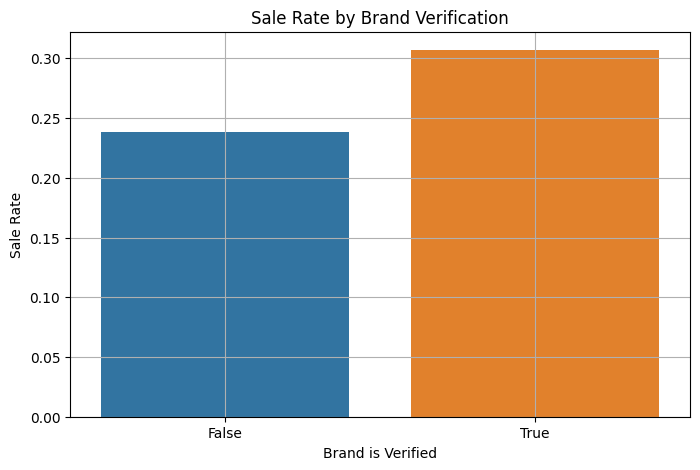

In [95]:
plt.figure(figsize=(8, 5))
sns.barplot(x='brand_is_verified', y='is_sold', data=brand_verification_sales_data, hue='brand_is_verified', legend=False)
plt.title('Sale Rate by Brand Verification')
plt.xlabel('Brand is Verified')
plt.ylabel('Sale Rate')
plt.grid(True)
plt.show()

Bar plot indicates that listings with verified brands have a higher sale rate compared to those where the brand is not verified. Which confirms that this is a possible feature that has influence.

#### Primary Color

In [96]:
color_sales_data = data.groupby('color_primary')['is_sold'].mean().reset_index().sort_values(by='is_sold', ascending=False)

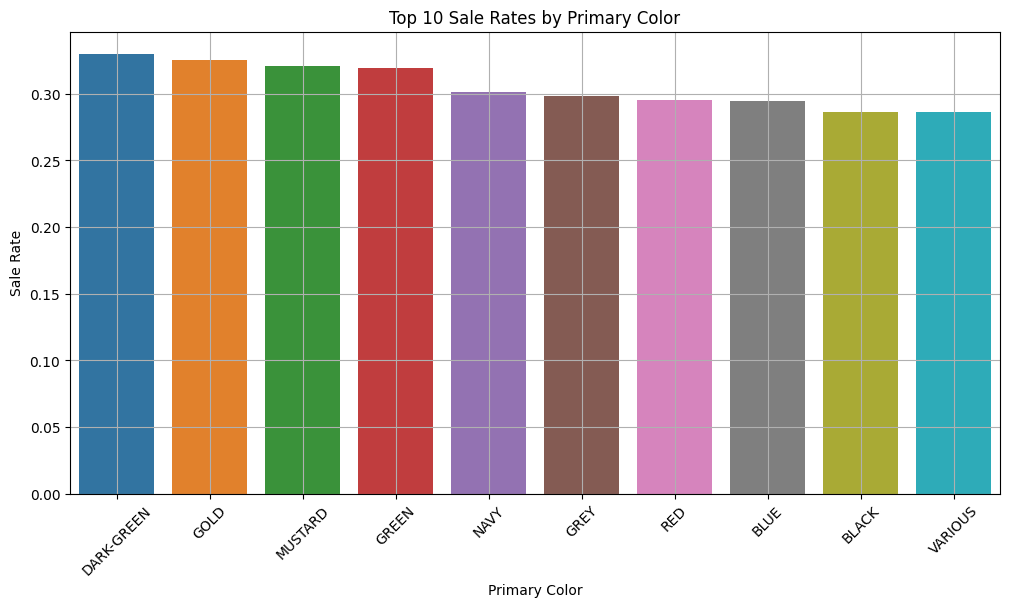

In [97]:
# top 10 selling colors =)
plt.figure(figsize=(12, 6))
sns.barplot(x='color_primary', y='is_sold', data=color_sales_data.head(10), hue='color_primary', legend=False)
plt.title('Top 10 Sale Rates by Primary Color')
plt.xlabel('Primary Color')
plt.ylabel('Sale Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [98]:
top_color_names = [name for name in color_sales_data.head(10)['color_primary']]
print(f"Top Colors by STR: {top_color_names}")

Top Colors by STR: ['DARK-GREEN', 'GOLD', 'MUSTARD', 'GREEN', 'NAVY', 'GREY', 'RED', 'BLUE', 'BLACK', 'VARIOUS']


Bar plot shows the top 10 primary colors with the highest sale rates. Certain colors seem to have higher STR, which confirms that this is a possible feature that has influence.

#### Listing Quality

In [99]:
data['listing_quality_category'] = data['listing_quality_string'].fillna('No additional details')

quality_category_sales_data = data.groupby('listing_quality_category')['is_sold'].mean().reset_index()

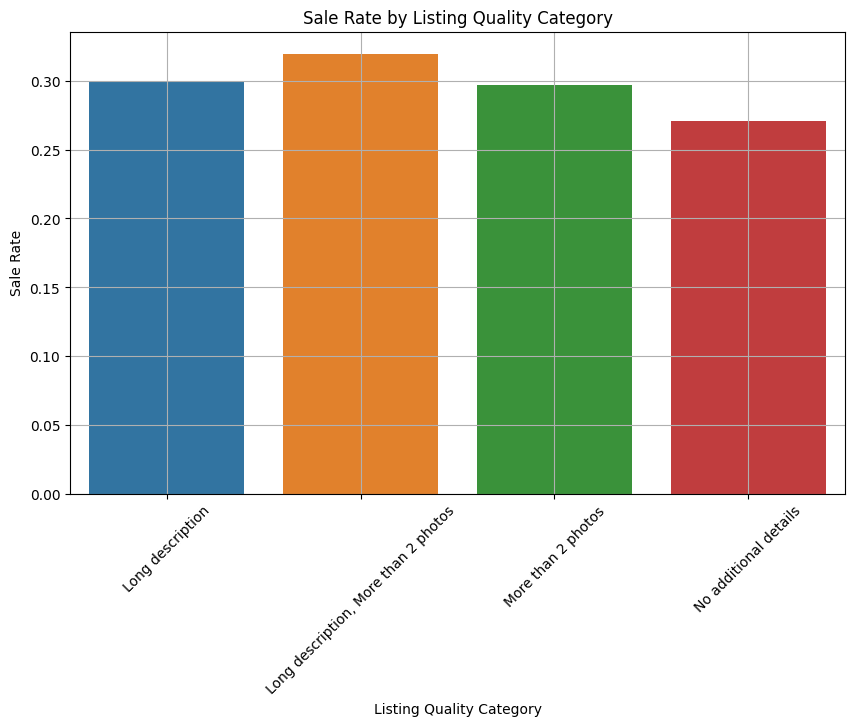

In [100]:
plt.figure(figsize=(10, 6))
sns.barplot(x='listing_quality_category', y='is_sold', data=quality_category_sales_data, hue='listing_quality_category', legend=False)
plt.title('Sale Rate by Listing Quality Category')
plt.xlabel('Listing Quality Category')
plt.ylabel('Sale Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Bar plot indicates that there is a probability for a significant difference between different Listing Quality Categories.

#### Listing Platform

In [101]:
listing_platform_sales_data = df.groupby('listing_platform')['is_sold'].mean().reset_index().sort_values(by='is_sold', ascending=False)

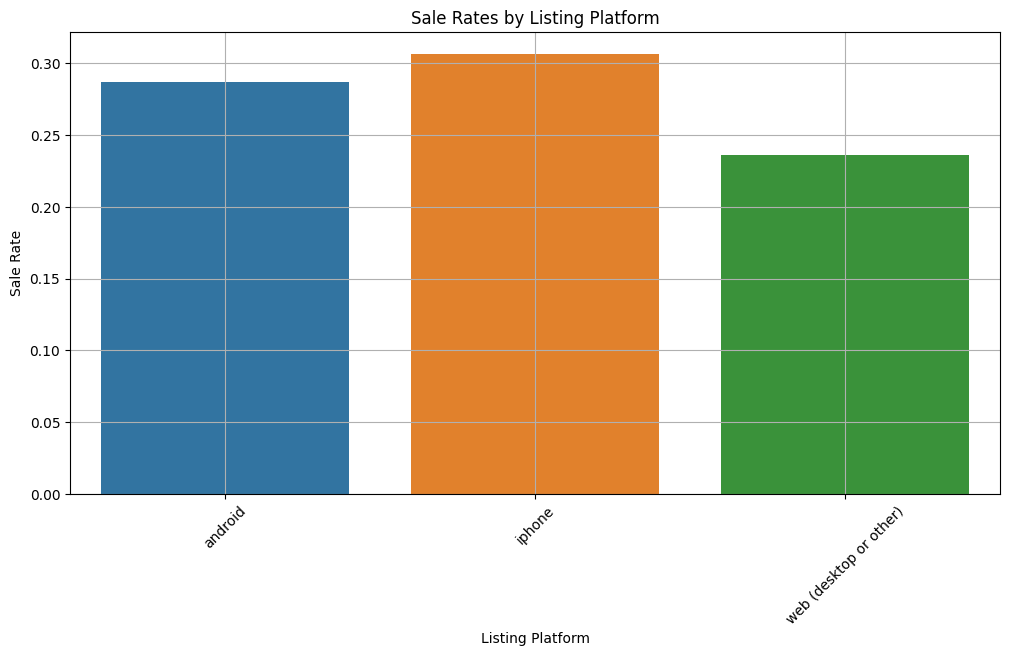

In [102]:
plt.figure(figsize=(12, 6))
sns.barplot(x='listing_platform', y='is_sold', data=listing_platform_sales_data, hue='listing_platform', legend=False)
plt.title('Sale Rates by Listing Platform')
plt.xlabel('Listing Platform')
plt.ylabel('Sale Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Bar plot indicates that there is a difference between STR and listing platform. Which confirms that this is possibly important feature that has influence.

#### Catalog Codes

In [103]:
catalog_codes_1_sales_data = data.groupby('catalog_code_1')['is_sold'].mean().reset_index().sort_values(by='is_sold', ascending=False)
catalog_codes_2_sales_data = data.groupby('catalog_code_2')['is_sold'].mean().reset_index().sort_values(by='is_sold', ascending=False)
# and so on

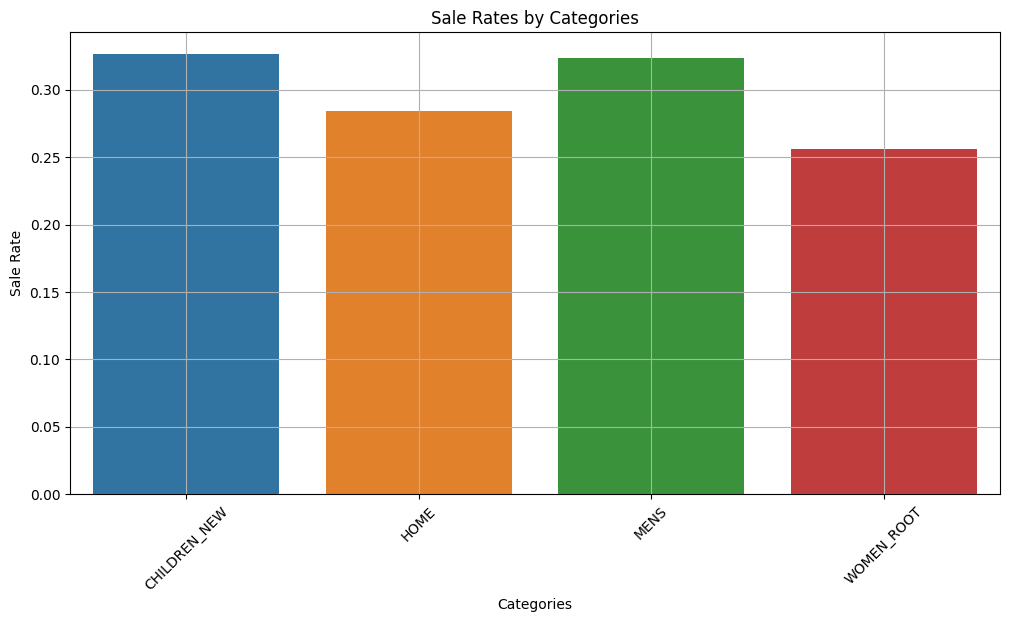

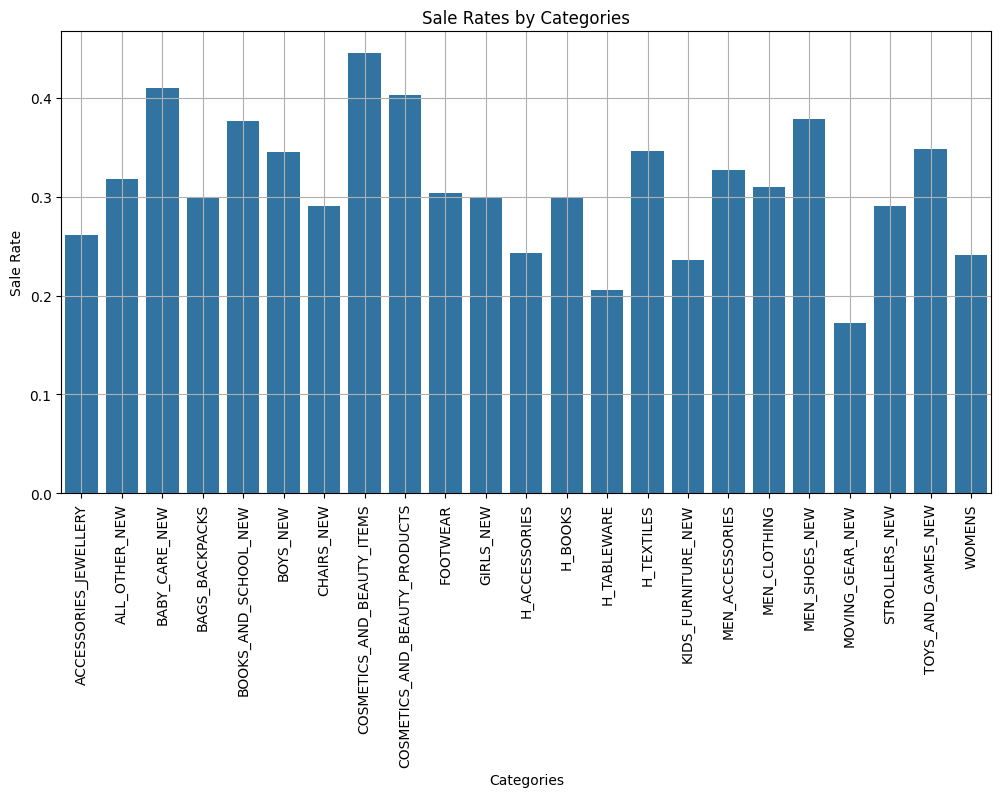

In [104]:
plt.figure(figsize=(12, 6))
sns.barplot(x='catalog_code_1', y='is_sold', data=catalog_codes_1_sales_data, hue='catalog_code_1', legend=False)
plt.title('Sale Rates by Categories')
plt.xlabel('Categories')
plt.ylabel('Sale Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x='catalog_code_2', y='is_sold', data=catalog_codes_2_sales_data)
plt.title('Sale Rates by Categories')
plt.xlabel('Categories')
plt.ylabel('Sale Rate')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Both barplots indicate that different categories influence STR value.

### Exculded Factors
- User Country, Portal, etc.: there might be a difference in shipping costs, though it is most probably does not infuence STR.
- Declined Listings: declined listings are no longer active and are irrelevant to STR calculations.

## ML Model

### Data preparation

In [105]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

In [106]:
df_model = data.copy()

In [107]:
# removing rows containing 'O' and '1' from 'gender' column 
# as they take very little space in dataset and most probably insignificant
df_model = df_model[~df_model['gender'].isin(['O', '1'])]
df_model['gender'] = df_model['gender'].cat.remove_unused_categories()

In [108]:
# normalizing numerical values
scaler = MinMaxScaler()

columns_to_normalize = [
    'listing_age_days', 
    'listing_price_eur_fixed', 
    'lister_nth_listing', 
    'total_positive_feedback_count', 
    'total_negative_feedback_count', 
    'window_items_listed', 
    'window_items_bought'
]

for column in columns_to_normalize:
    df_model[f'{column}_normalized'] = scaler.fit_transform(df_model[[column]])

In [109]:
# preparing dummy variables for categoruical columns
df_categorical_class = pd.get_dummies(df_model[['status', 'color_primary', 'catalog_code_1', 'gender', 'listing_platform']])
df_numerical_class = df_model[['listing_price_eur_fixed_normalized', 'total_positive_feedback_count_normalized', 
                                'total_negative_feedback_count_normalized', 'window_items_listed_normalized', 'is_sold']]

df_processed = pd.concat([df_numerical_class, df_categorical_class], axis=1)

### Training model

In [110]:
X = df_processed.drop('is_sold', axis=1)
y = df_processed['is_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

feature_importance = model.feature_importances_
feature_names = X.columns.tolist()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance_df)

Accuracy: 0.7085891876989399
Feature Importance:
                                     Feature  Importance
40                 catalog_code_1_WOMEN_ROOT    0.111832
4                    status_a. New with tags    0.064177
45   listing_platform_web (desktop or other)    0.043746
44                   listing_platform_iphone    0.041800
37               catalog_code_1_CHILDREN_NEW    0.039796
7                             status_d. Good    0.037558
1   total_positive_feedback_count_normalized    0.034210
28                        color_primary_PINK    0.032162
42                                  gender_M    0.029505
17                  color_primary_DARK-GREEN    0.024373
15                       color_primary_CORAL    0.023124
33                   color_primary_TURQUOISE    0.022955
25                     color_primary_MUSTARD    0.022907
19                       color_primary_GREEN    0.022802
10                       color_primary_BLACK    0.022787
0         listing_price_eur_fixed_norma

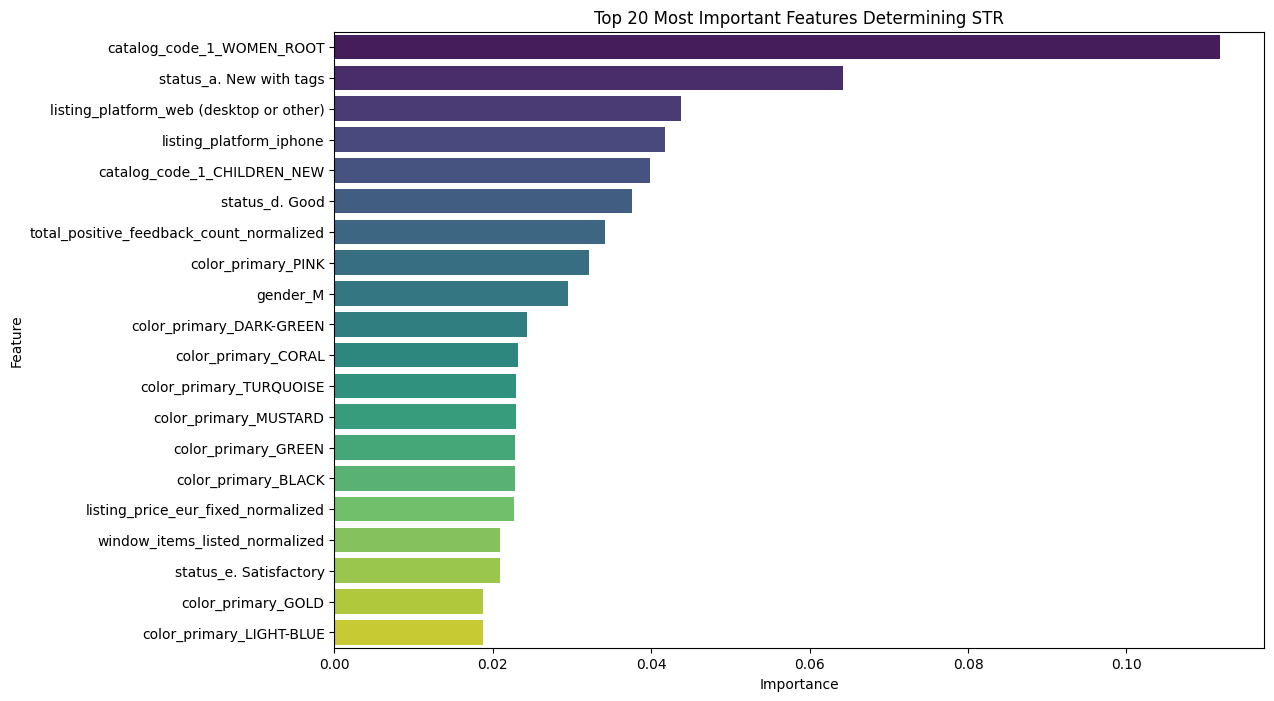

In [111]:
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)  # Adjust number for more/less features

plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features Determining STR')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Model’s Performance**
Model has an accuracy of ~ 70.86%. While this is a decent number, but there is definetley room for improvement.

*Ways to improve*:
- Feature Enhancement: cexploring further into features and trying to come up with new feature metrics.
- Model Tuning: trying to adjust parameters of model, like tree depth, learning_rate, etc.
- Data Quality: exploring if data is not clean and if so - better validating that data is clean.

# Section III: Improving Liquidity

## Features to focus on:
- Catalog Codes: especially ones like (WOMEN_ROOT, CHILDREN_NEW, HOME), as they seem to impact liquidity significantly. For example, further enhance appearence and attractivness of those categories.
- Listing Quality: promote or highlight listings with good descriptions, as they probably will sell better.
- Listing Platform: improve experience for users on platforms which lag behind in importance and STR.

## Concrete applications:
- Catalog Codes: create marketing campaings for important categories to further attract more buyers and increase STR.
- Listing quality: provide some tutorials to user on how to create a good quality listing, showcasing that listings with good descriptions are sold quicker.
- Listing platforms: further analyze why there is a difference between STRs and feature importance of different platforms. Upon finding more insight experience between different platforms can be optimized.  